### Processing DEM

In [22]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import fiona
import rasterio
import rasterio.mask
from rasterio import shutil as rio_shutil
import pickle
import flopy
from shapely.geometry import Polygon
import geopandas as gpd

In [23]:
### TURN ASCII FILES INTO GEOTIFFS - NO NEED TO DO THIS AGAIN!!!!! ######
def make_geotif():
    # Create a geotiff from the DEM
    with rasterio.open("../Data/data_dem/output_hh.asc") as src:
        print(src)
        rio_shutil.copy(src, "../Data/data_dem/output_hh.tif", driver="GTiff")
#make_geotif()

In [24]:
# PRINT DETAILS OF THE GEOTIFF FILE
geotiff_file = "../Data/data_dem/output_hh.tif"

with rasterio.open(geotiff_file) as src:
    print("Current CRS:", src.crs)
    transform = src.transform     # Get the affine transformation
    origin_x, origin_y = transform.c, transform.f  # Extract the origin (upper-left corner)
    print(f"Origin (Upper-Left Corner): X = {origin_x}, Y = {origin_y}")

Current CRS: None
Origin (Upper-Left Corner): X = 113.796249988889, Y = -27.302083318079


In [42]:
# Convert to UTM
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Input file
input_path = "../Data/data_dem/output_hh.tif"
output_path = "../Data/data_dem/output_hh_UTM.tif"

# Open input raster
with rasterio.open(input_path) as src:
    # Auto-detect UTM zone from raster centroid
    lon, lat = (src.bounds.left + src.bounds.right) / 2, (src.bounds.top + src.bounds.bottom) / 2
    zone_number = int((lon + 180) / 6) + 1
    hemisphere = '327' if lat >= 0 else '327'  # 326 = north, 327 = south
    utm_epsg = 'EPSG:28350'#f"EPSG:{hemisphere}{zone_number}"

    print(f"Reprojecting to {utm_epsg}...")

    # Calculate transform
    transform, width, height = calculate_default_transform(
        src.crs, utm_epsg, src.width, src.height, *src.bounds)
    
    # Update metadata
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': utm_epsg,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Reproject
    with rasterio.open(output_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=utm_epsg,
                resampling=Resampling.nearest)

Reprojecting to EPSG:28350...


THE CHUNK ABOVE WAS SUPPOSED TO CONVERT TO EASTINGS AND NORTHINGS!!!

In [43]:
# PRINT DETAILS OF THE GEOTIFF FILE
geotiff_file = "../Data/data_dem/output_hh_UTM.tif"

with rasterio.open(geotiff_file) as src:
    print("Current CRS:", src.crs)
    transform = src.transform     # Get the affine transformation
    origin_x, origin_y = transform.c, transform.f  # Extract the origin (upper-left corner)
    print(f"Origin (Upper-Left Corner): X = {origin_x}, Y = {origin_y}")

Current CRS: EPSG:28350
Origin (Upper-Left Corner): X = 113.796249988889, Y = -27.302083318079


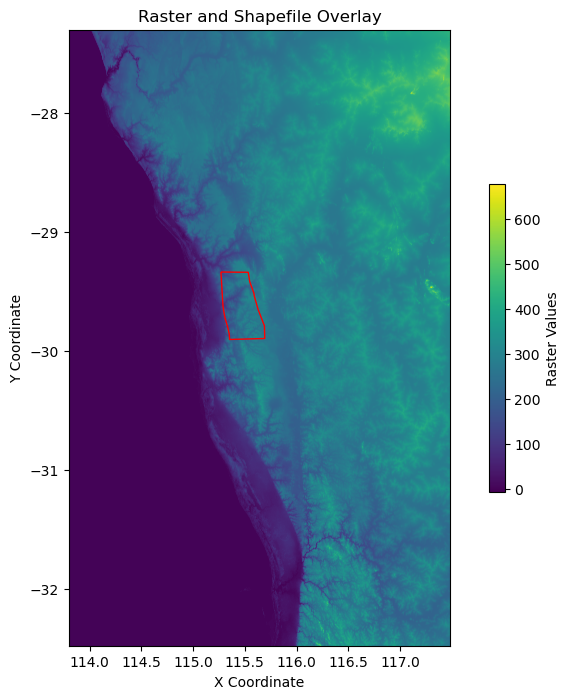

In [44]:
def plot_raster_polygon(raster_path, shapefile_path):

    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)  # Read the first band
        raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    gdf = gpd.read_file(shapefile_path)

    plt.figure(figsize=(10, 8))
    plt.imshow(raster_data, extent=raster_extent, cmap='viridis', origin='upper')
    plt.colorbar(label='Raster Values', shrink=0.5)
    gdf.boundary.plot(ax=plt.gca(), color='red', linewidth=1)

    plt.title("Raster and Shapefile Overlay")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()


raster_path = "../Data/data_dem/output_hh_UTM.tif"
shapefile_path = "../Data/Data_shp/Otorowiri_Model_Extent.shp"
plot_raster_polygon(raster_path, shapefile_path)

In [45]:
## CROP THE RASTER TO THE SHAPEFILE EXTENT
from shapely.geometry import mapping

# Path to the raster file
raster_path = "../Data/data_dem/output_hh_UTM.tif"
shapefile_path = "../Data/Data_shp/Otorowiri_Model_Extent.shp"
gdf = gpd.read_file(shapefile_path)
polygon = gdf.geometry.iloc[0]

geojson_geom = [mapping(polygon)]

with rasterio.open(raster_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, geojson_geom, crop=True)
    out_meta = src.meta.copy()

# Update metadata for the cropped raster
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save the cropped raster to a new file
output_path = "../Data/data_dem/cropped_raster.tif"
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)

print(f"Cropped raster saved to: {output_path}")

Cropped raster saved to: ../Data/data_dem/cropped_raster.tif


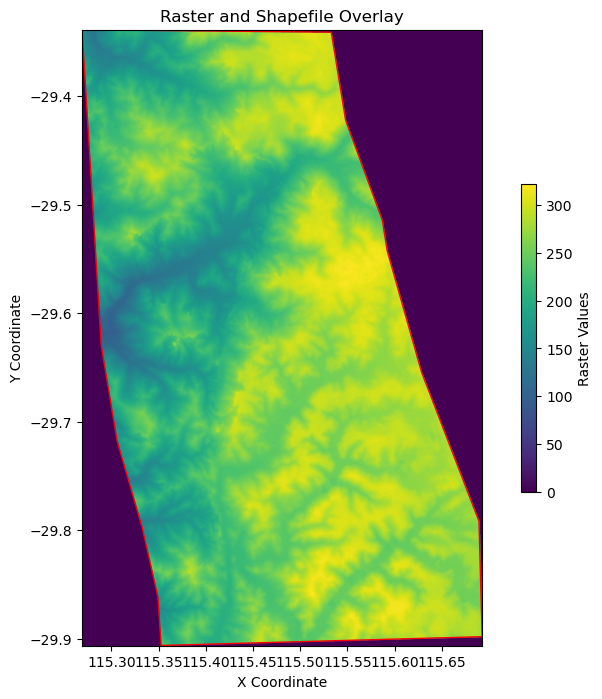

In [46]:
raster_path = "../Data/data_dem/cropped_raster.tif"
shapefile_path = "../Data/Data_shp/Otorowiri_Model_Extent.shp"
plot_raster_polygon(raster_path, shapefile_path)

In [48]:
def resample_topo(self, project, mesh):
    fine_topo = flopy.utils.Raster.load('../Data/data_dem/cropped_raster.tif')
    #topo_cropped = fine_topo.crop(model_boundary_poly)
    topo = fine_topo.resample_to_grid(mesh.vgrid, band=fine_topo.bands[0], method="linear", extrapolate_edges=True,)
    fname = '../Data/data_dem/topo.pkl'
    pickle.dump(topo, open(os.path.join(fname),'wb'))

In [ ]:
## USEFUL FUNCTIONS BELOW

class DEM:
    
    def __init__(self, geotiff_fname):   
        self.geotiff_fname = geotiff_fname


    def crop_raster(self, bbox_path):
        with fiona.open(bbox_path, "r") as shapefile:
            shapes = [feature["geometry"] for feature in shapefile]
        
        with rasterio.open(self.geotiff_fname) as src:
            print(src.crs)
            out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
            out_meta = src.meta
        
        out_meta.update({"driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform})
        
        with rasterio.open("../data/data_dem/cropped_raster.tif", "w", **out_meta) as dest:
            print(dest.crs)
            dest.write(out_image)

    def resample_topo(self, project, structuralmodel, nrow, ncol, fname):
        fine_topo = flopy.utils.Raster.load(self.geotiff_fname)
        delr = np.ones((ncol)) * ((structuralmodel.x1 - structuralmodel.x0)/ncol)
        delc = np.ones((nrow)) * ((structuralmodel.y1 - structuralmodel.y0)/nrow)
        resample_grid = flopy.discretization.structuredgrid.StructuredGrid(delc = delc, delr = delr, xoff = structuralmodel.x0, yoff = structuralmodel.y0)
        self.resample_grid = resample_grid
        resampled_topo = fine_topo.resample_to_grid(resample_grid, band=fine_topo.bands[0], method="linear", extrapolate_edges=True,)

        # Create a list x,y,z to put in structural model
        xyzcenters = resample_grid.xyzcellcenters
        xcenters = xyzcenters[0][0]
        ycenters = [xyzcenters[1][i][0] for i in range(nrow)]
        topo_xyz = []
        for col in range(ncol):
            for row in range(nrow):
                topo_xyz.append((xcenters[col], ycenters[row], resampled_topo[col, row]))
        
        pickle.dump(topo_xyz, open(os.path.join(fname),'wb'))
        return resampled_topo

    def load_topo(self, project):
        pickleoff = open(project.workspace + 'topo.pkl','rb')
        self.topo = pickle.load(pickleoff)
        pickleoff.close()

    def plot_geotiff(self):
        with rasterio.open(self.geotiff_fname) as src:
            data = src.read(1)
            nodata_value = src.nodata
    
        if nodata_value is not None:
            masked_data = np.ma.masked_equal(data, nodata_value)
        else:
            masked_data = data  # If no NoData value is set, use the data as is
        
        plt.figure(figsize=(10, 8))
        plt.imshow(masked_data, cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Data Values', shrink = 0.5)
        plt.title('GeoTIFF Visualization (NoData Values Excluded)')
        plt.xlabel('Column Number')
        plt.ylabel('Row Number')
        plt.show()
    
    def plot_topo(self, levels):
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        ax.set_title('Top Elevation (m)')
        pmv = flopy.plot.PlotMapView(modelgrid=self.resample_grid)
        t = pmv.plot_array(self.topo)#, ec="0.75")
        cbar = plt.colorbar(t, shrink = 0.5)  
        cg = pmv.contour_array(self.topo, levels=levels, linewidths=0.8, colors="0.75")